In [95]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START,END,StateGraph
from pydantic import BaseModel,Field
from dotenv import load_dotenv
from typing import TypedDict,Literal
import os
load_dotenv()

True

In [96]:
# loading the model
api_key=os.getenv('GOOGLE_API_KEY')
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite-preview-09-2025',temperature=0.2,api_key=api_key)

In [97]:
class SentimentSchema(BaseModel):
    sentiment:Literal['positive','negative']=Field(description='Sentiment of the review') 

In [98]:
structured_model=model.with_structured_output(SentimentSchema)

In [99]:
class diagnosisSchema(BaseModel):
    issue_type:Literal['UI','Features','Payment Mode','Network Issue']
    tone:Literal['calm','frustrated','angry','casual']
    urgency:Literal['normal','urgent','calm','few-days']

In [100]:
diagnosis_model=model.with_structured_output(diagnosisSchema)

In [101]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal['positive','negative']
    diagnosis:dict
    response:str

In [102]:
def find_sentiment(state:ReviewState):
    prompt=f'For the following review find out the sentiment of the following review\n {state['review']}'
    sentiment=structured_model.invoke(prompt).sentiment
    return {'sentiment':sentiment}

def check_sentiment(state:ReviewState)->Literal['positive_response','run_diagnosis']:
    if state['sentiment']=='positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'


In [103]:
def run_diagnosis(state:ReviewState):
    prompt=f'Diagnosis this negative review {state['review']}'
    response=diagnosis_model.invoke(prompt)
    return{'diagnosis':response}
    

In [104]:
def positive_response(state:ReviewState):
    prompt=f'Write the warm thankyou message for the following feedback\n {state['review']}'
    response=model.invoke(prompt)
    return {'response':response.content}

In [105]:
def review_negative(state:ReviewState):
    diagnosis=state['diagnosis'].dict()
    review=state['review']
    prompt=f'Write the sorry message for this {review}, The user had this issue {diagnosis['issue_type']} , and is this {diagnosis['urgency']} and giving the response in this tone {diagnosis['tone']}'
    response=model.invoke(prompt)
    return {'response':response.content}

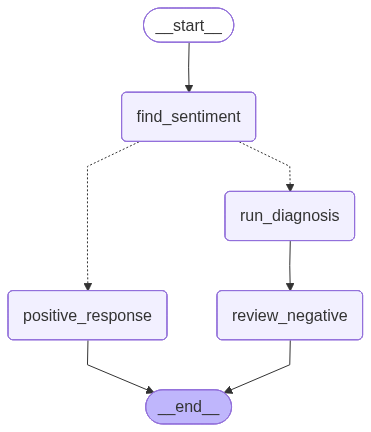

In [106]:
# make the graph
graph=StateGraph(ReviewState)

# make the nodes
graph.add_node('review_negative',review_negative)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('find_sentiment',find_sentiment)

# add the edges
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','review_negative')
graph.add_edge('review_negative',END)

# make the workflow
workflow=graph.compile()
workflow

In [107]:
initial_state={
    'review':'Completely disappointed! The product stopped working within a week and customer service is unhelpful. Fix this immediately!'
}

In [108]:
result=workflow.invoke(initial_state)
result

C:\Users\rijan\AppData\Local\Temp\ipykernel_5388\2856729728.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  diagnosis=state['diagnosis'].dict()


{'review': 'Completely disappointed! The product stopped working within a week and customer service is unhelpful. Fix this immediately!',
 'sentiment': 'negative',
 'diagnosis': diagnosisSchema(issue_type='Features', tone='angry', urgency='urgent'),
 'response': 'Here are a few options for a sorry message, keeping the angry tone in mind, while still aiming to address the user\'s urgent issue:\n\n**Option 1 (Direct and Demanding):**\n\n> **ARE YOU KIDDING ME?!** A week? And your "customer service" is useless? This is **COMPLETELY UNACCEPTABLE!** You need to fix this **RIGHT NOW**. I expect an immediate resolution to this faulty product and the abysmal support I\'ve received. Don\'t give me excuses, **FIX IT.**\n\n**Option 2 (Slightly More Formal, but Still Angry):**\n\n> I am beyond furious. This product failing in a week is a joke, and your customer service has been a complete waste of time. This is **URGENT**. I demand an immediate and effective solution to this problem. **GET THIS RE

In [109]:
initial_state1={
    'review':'The product has potential, but the design and usability need improvement. I hope future versions address these issues.'
}

In [110]:
result1=workflow.invoke(initial_state1)
result1

C:\Users\rijan\AppData\Local\Temp\ipykernel_5388\2856729728.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  diagnosis=state['diagnosis'].dict()


{'review': 'The product has potential, but the design and usability need improvement. I hope future versions address these issues.',
 'sentiment': 'negative',
 'diagnosis': diagnosisSchema(issue_type='UI', tone='frustrated', urgency='normal'),
 'response': 'Here are a few options for a frustrated apology, playing on different shades of annoyance:\n\n**Option 1 (Direct & Slightly Exasperated):**\n\n> Ugh, look, I\'m sorry the UI is giving you such a headache. Honestly, we *know* it\'s not where it needs to be. We see the potential in the product, but yeah, the design and usability are clearly a major roadblock right now. We\'re definitely aware and *hope* future versions actually fix these glaring issues.\n\n**Option 2 (More Focused on the User\'s Pain):**\n\n> Seriously, I apologize that the UI experience is so frustrating for you. It\'s clearly not intuitive, and that\'s on us. We see the core concept has legs, but dealing with a clunky design is just infuriating. We\'re banking on fu